# Examples

Taken from _DisCoPy: the Hierarchy of Graphical Languages in Python_ ([arXiv:2311.10608](https://arxiv.org/abs/2311.10608))

## A diagram as a list of layers

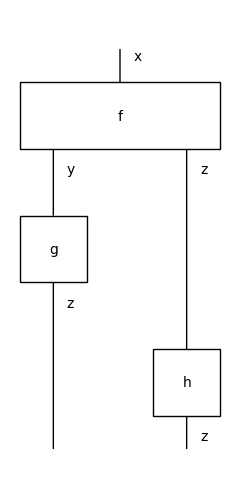

In [1]:
from discopy.monoidal import Ty, Box, Layer, Diagram

x, y, z = Ty('x'), Ty('y'), Ty('z')
f, g, h = Box('f', x, y @ z), Box('g', y, z), Box('h', z, z)

assert f >> g @ h == Diagram(
    dom=x, cod=z @ z, inside=(
        Layer(Ty(), f, Ty()),
        Layer(Ty(), g, z),
        Layer(z,    h, Ty())))

(f >> g @ h).draw()


## Boolean circuits as a subclass of Diagram

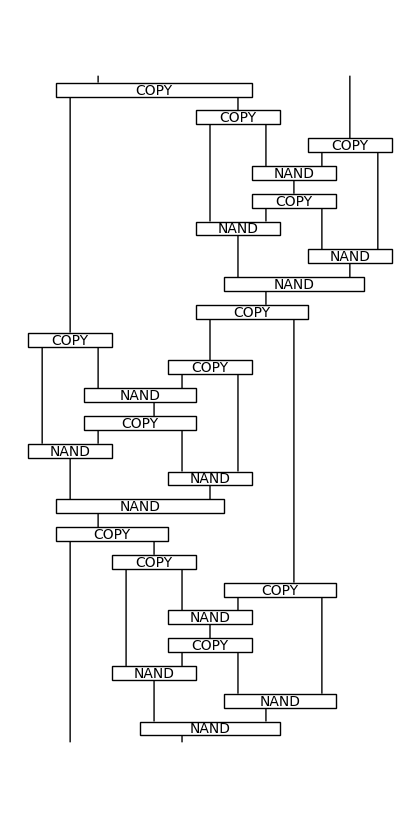

In [2]:
from discopy import monoidal, python
from discopy.cat import factory, Category

@factory  # Ensure that composition of circuits remains a circuit.
class Circuit(monoidal.Diagram):
    ty_factory = monoidal.PRO  # Use natural numbers as objects.

    def __call__(self, *bits):
        F = monoidal.Functor(
            ob=lambda _: bool, ar=lambda f: f.data,
            cod=Category(python.Ty, python.Function))
        return F(self)(*bits)

class Gate(monoidal.Box, Circuit):
    """A gate is just a box in a circuit with a function as data."""

NAND = Gate("NAND", 2, 1, data=lambda x, y: not (x and y))
COPY = Gate("COPY", 1, 2, data=lambda x: (x, x))

XOR = COPY @ COPY >> 1 @ (NAND >> COPY) @ 1 >> NAND @ NAND >> NAND
CNOT = COPY @ 1 >> 1 @ XOR
NOTC = 1 @ COPY >> XOR @ 1
SWAP = CNOT >> NOTC >> CNOT  # Exercise: Find a cheaper SWAP circuit!

assert all(SWAP(x, y) == (y, x) for x in [True, False]
                                for y in [True, False])

SWAP.draw(figsize=(4, 8), draw_type_labels=False)


## Spirals as the worst-case for normalisation

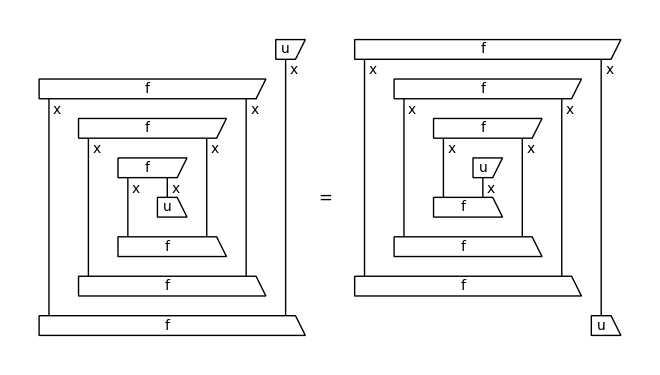

In [3]:
from discopy.monoidal import Ty, Box
from discopy.drawing import Equation

x = Ty('x')
f, u = Box('f', Ty(), x @ x), Box('u', Ty(), x)

def spiral(length):
    diagram, n = u, length // 2 - 1
    for i in range(n):
        diagram >>= x ** i @ f @ x ** (i + 1)
    diagram >>= x ** n @ u.dagger() @ x ** n
    for i in range(n):
        m = n - i - 1
        diagram >>= x ** m @ f.dagger() @ x ** m
    return diagram

assert spiral(8).dagger() != spiral(8)
assert spiral(8).dagger() == spiral(8).normal_form()

Equation(spiral(8), spiral(8).dagger()).draw()


## The golden ratio as the trace of a string diagram

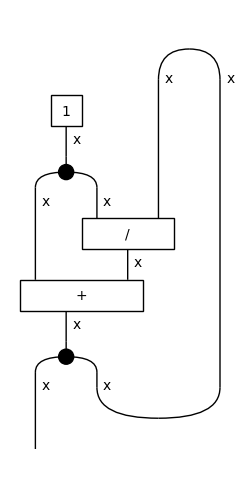

In [4]:
from discopy.traced import Ty, Box, Category, Functor
from discopy import python

x = Ty('x')
add, div, one = Box('+', x @ x, x), Box('/', x @ x, x), Box('1', Ty(), x)
copy = Box('', x, x @ x, draw_as_spider=True, color="black")

phi = ((one >> copy) @ x >> x @ div >> add >> copy).trace()

# The default y=1 is the initial value for the fixed point.
F = Functor(ob={x: float},
            ar={div: lambda x, y=1.: x / y,
                add: lambda x, y: x + y,
                copy: lambda x: (x, x),
                one: lambda: 1.},
            cod=Category(python.Ty, python.Function))

with python.Function.no_type_checking:
    assert F(phi)() == 0.5 * (1 + 5 ** 0.5)

phi.draw()


## The Kauffman bracket as a ribbon functor

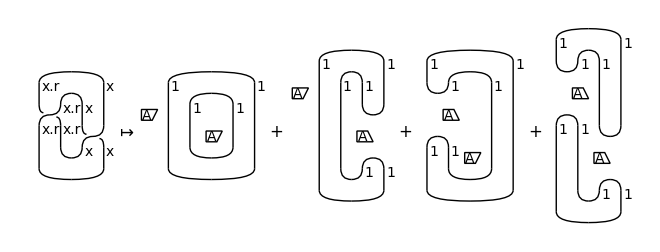

In [5]:
from discopy import ribbon, drawing
from discopy.cat import factory, Category

x = ribbon.Ty('x')
cup, cap, braid = ribbon.Cup(x.r, x), ribbon.Cap(x.r, x), ribbon.Braid(x, x)
link = cap >> x.r @ cap @ x >> braid.r @ braid >> x.r @ cup @ x >> cup

@factory
class Kauffman(ribbon.Diagram):
    ty_factory = ribbon.PRO

class Cup(ribbon.Cup, Kauffman): pass
class Cap(ribbon.Cap, Kauffman): pass
class Sum(ribbon.Sum, Kauffman): pass

Kauffman.cup_factory = Cup
Kauffman.cap_factory = Cap
Kauffman.sum_factory = Sum

class Variable(ribbon.Box, Kauffman): pass

Kauffman.braid = lambda x, y: (Variable('A', 0, 0) @ x @ y)\
    + (Cup(x, y) >> Variable('A', 0, 0).dagger() >> Cap(x, y))

K = ribbon.Functor(ob=lambda _: 1, ar={}, cod=Category(ribbon.PRO, Kauffman))
drawing.Equation(link, K(link), symbol="$\\mapsto$").draw()


## Checking the equality of two diagrams

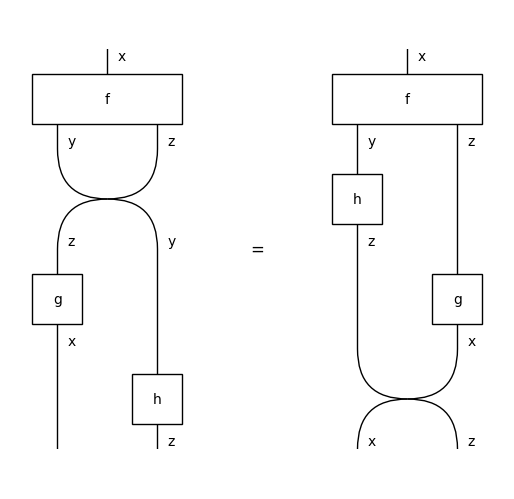

In [6]:
from discopy.symmetric import Ty, Box, Swap, Diagram

x, y, z = Ty('x'), Ty('y'), Ty('z')

f = Box('f', x, y @ z)
g, h = Box('g', z, x), Box('h', y, z)

diagram_left = f >> Swap(y, z) >> g @ h
diagram_right = f >> h @ g >> Swap(z, x)

assert diagram_left != diagram_right

with Diagram.hypergraph_equality:
    assert diagram_left == diagram_right

drawing.Equation(diagram_left, diagram_right).draw()


## Defining a diagram from a Python function

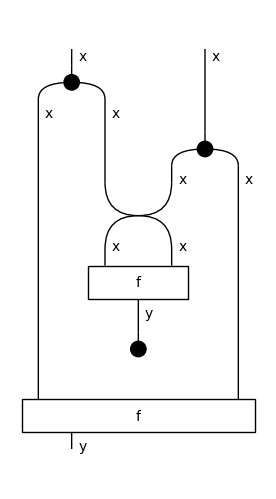

In [7]:
from discopy.markov import *

x, y = Ty('x'), Ty('y')
f = Box('f', x @ x, y)

@Diagram.from_callable(x @ x, y)
def diagram(a, b):  # Take two wires as inputs
    _ = f(b, a)     # Swap, apply f and discard the result.
    return f(a, b)  # Apply f again and return the result.

assert diagram == Copy(x) @ Copy(x)\
    >> x @ (Swap(x, x) >> f >> Discard(y)) @ x >> f

diagram.draw()


## The hypergraph representation of a diagram

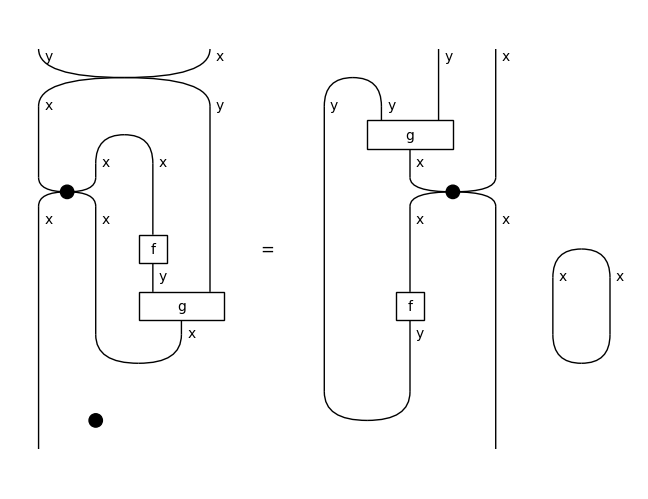

In [8]:
from discopy.frobenius import *

x, y = Ty('x'), Ty('y')
f, g = Box('f', x, y), Box('g', y @ y, x)

diagram_lhs = Swap(y, x) >> x @ Cap(x, x) @ y >> Spider(2, 2, x) @ f @ y >> x @ x @ g\
    >> x @ Cup(x, x) @ Spider(0, 0, x)

diagram_rhs = Cap(y, y) @ y @ x >> y @ g @ x >> y @ Spider(2, 2, x) @ Cap(x, x)\
    >> y @ f @ x @ Cup(x, x) >> Cup(y, y) @ x

a, b, c, d = "abcd"
hypergraph = Hypergraph(
    dom=y @ x, cod=x, boxes=(f, g),
    wires=((c, a),           # input wires of the hypergraph
           (((a, ), (b, )),    # input and output wires of f
            ((b, c), (a, ))),  # input and output wires of g
           (a, )),           # output wire of the hypergraph
    spider_types={a: x, b: y, c: y, d: x})  # note the extra x

assert diagram_lhs.to_hypergraph() == hypergraph == diagram_rhs.to_hypergraph()

drawing.Equation(diagram_lhs, diagram_rhs).draw()


## First-order logic with diagrams

As pioneered by C.S. Peirce: boxes are predicates, spiders are variables and bubbles are negation.

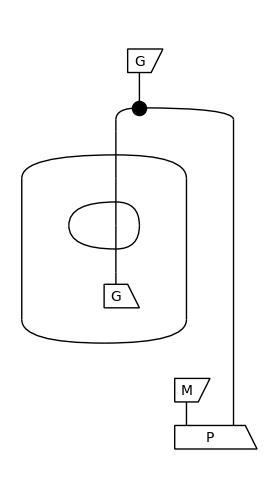

In [9]:
from discopy.frobenius import *
from discopy.tensor import Dim, Tensor

Tensor[bool].bubble = lambda self, **_: self.map(lambda x: not x)

@factory
class Formula(Diagram):
    ty_factory = PRO

    def eval(self, size, model):
        return Functor(
            ob=lambda _: Dim(size), ar=lambda f: model[f],
            cod=Category(Dim, Tensor[bool]))(self)

class Cut(Bubble, Formula): pass
class Ligature(Spider, Formula): pass
class Predicate(Box, Formula): pass

P = Predicate("P", 0, 2)  # A binary predicate, i.e. a relation.
G, M = [Predicate(unary, 0, 1) for unary in ("G", "M")]
p, g, m = [[0, 1], [0, 0]], [0, 1], [1, 0]
size, model = 2, {G: g, M: m, P: p}

formula = G >> Ligature(1, 2, PRO(1))\
    >> Cut(Cut(Formula.id(1)) >> G.dagger())\
    @ (M @ 1 >> P.dagger())

assert bool(formula.eval(size, model)) == any(
    g[x] and all(not g[y] or x == y for y in range(size))
    and m[z] and p[z][x] for x in range(size) for z in range(size))

formula.draw(draw_type_labels=False)
